In [140]:
import pyspark
from   pyspark.sql import SparkSession
from   pyspark.sql.functions import to_date, date_format
import pyspark.sql.functions as F
from   matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions
%matplotlib inline

In [141]:
DB_HOST = 'challenge.prod.public.data.escale.com.br'
DB_NAME = 'challenge'
DB_PORT = '5432'
DB_USER = 'challenge'
DB_PASS = '******'
SPARK_APP = 'Case Escale'

In [142]:
spark = SparkSession \
        .builder \
        .appName(SPARK_APP) \
        .config("spark.jars", "/path_to_postgresDriver/postgresql-postgresql-42.2.19.jre7.jar") \
        .getOrCreate()

In [143]:
# Funcao que recebe as variaveis contendo o host e credenciais para acessar a base de dados

def tableReader(tableName):
  global DB_HOST
  global DB_NAME
  global DB_PORT
  global DB_USER
  global DB_PASS
  tempDf = spark.read \
            .format("jdbc") \
            .option("url", f"jdbc:postgresql://{DB_HOST}:{DB_PORT}/{DB_NAME}") \
            .option("dbtable", tableName) \
            .option("user", DB_USER) \
            .option("password", DB_PASS) \
            .option("driver", "org.postgresql.Driver") \
            .load()
  return tempDf

In [111]:
def executeQuery(query):
    tempDf = spark.sql(query)
    return tempDf.toPandas()

In [112]:
##
attendacesDf = tableReader("attendances")
attendancesCallsDf = tableReader("attendances_calls")

In [113]:
# Relacionamento entre as tabelas Attendances e Attendances_call

newAttendacesDf = attendancesCallsDf.join(attendacesDf, attendancesCallsDf.attendance_id == attendacesDf.id, how="inner")

In [114]:
# Criacao do Dataframe newAttendacesDf contendo apenas as colunas necessarias para elaboracao dos kpis

newAttendacesDf = newAttendacesDf.select(F.col("attendance_id"),
                                         F.col("token").alias("token_key"),
                                         F.col("main_connection"),
                                         F.when(F.col("type_id") == 1, "Venda").otherwise("Não Venda").alias("record_type"),
                                         F.col("monthly_value").alias("monthly_amount")) \
                                  .dropDuplicates()

newAttendacesDf = newAttendacesDf.withColumn("attendance_key", F.monotonically_increasing_id())

newAttendacesDf.createOrReplaceTempView("dim_attendance")


In [115]:
##
lineMKTFinalDf = tableReader("lines_mkt_final")

In [116]:
newlineMKTFinalDf = lineMKTFinalDf.select(F.col("id").alias("line_key"),
                                          F.col("line_id"),
                                          F.col("midia"),
                                          F.col("campanha").alias("campaign"),
                                          F.col("fonte").alias("source"),
                                          F.col("pagina").alias("web_page"))\
                                   .dropDuplicates()
newlineMKTFinalDf.createOrReplaceTempView("dim_line_mkt")


In [117]:
calendarDf = spark.sql("SELECT sequence(to_date('2020-01-01'), to_date('2020-12-31'), interval 1 day) as date")
calendarDf = calendarDf.withColumn("date", F.explode(F.col("date")))
calendarDf = calendarDf.withColumn("day", F.dayofmonth("date"))
calendarDf = calendarDf.withColumn("month", F.month("date"))
calendarDf = calendarDf.withColumn("year", F.year("date"))
calendarDf = calendarDf.withColumn("quarter", F.quarter("date"))

In [118]:
#callHistoryQueueDf = callHistoryQueueDf.join(newCalendarDf, newCalendarDf.date == callHistoryQueueDf.created_at, how="inner")

newCalendarDf = calendarDf.select(F.col("date"),
                                     F.col("day"),
                                     F.col("month"),
                                     F.col("quarter"),
                                     F.col("year"))\
                                     .dropDuplicates()

newCalendarDf.createOrReplaceTempView("dim_calendar")      


In [119]:
callHistoryQueueDf = tableReader("call_history_queue")
modalityDf = tableReader("telephony_types")
callStatusDf = tableReader("telephony_types")
groupCallDf = tableReader("telephony_types")

In [120]:
modalityDf = modalityDf.selectExpr("id as modality_id", "description as modality")\
                       .dropDuplicates()
                           
callStatusDf = callStatusDf.selectExpr("id as verb_type_id", "description as call_status")\
                           .dropDuplicates()
                           
groupCallDf = groupCallDf.selectExpr("id as line_type_id", "description as call_group")\
                         .dropDuplicates()
                                             
newCallHistoryQueueDf = callHistoryQueueDf.join(modalityDf,
                                                callHistoryQueueDf.queue_log_modality_types_id == modalityDf.modality_id,
                                                how="left")

newCallHistoryQueueDf = newCallHistoryQueueDf.join(callStatusDf,
                                                   callHistoryQueueDf.queue_log_verb_types_id == callStatusDf.verb_type_id,
                                                   how="left")
                                             
newCallHistoryQueueDf = newCallHistoryQueueDf.join(groupCallDf,
                                                   callHistoryQueueDf.queue_log_line_types_id == groupCallDf.line_type_id,
                                                   how="left")

newCallHistoryQueueDf = newCallHistoryQueueDf.select(F.col("id").alias("call_key"),
                                                  F.col("id").alias("call_id"),
                                                  F.col("token").alias("token_key"),
                                                  F.col("lines_id").alias("line_id"),
                                                  F.col("modality"),
                                                  F.col("call_status"),
                                                  F.col("call_group"),
                                                  F.col("uf"),
                                                  F.col("duration"),
                                                  F.col("agent"),
                                                  F.to_date("created_at", "yyyy-MM-dd").alias("created_at"))\
                                          .dropDuplicates()
newCallHistoryQueueDf.createOrReplaceTempView("fact_call")

In [126]:
query01="""
select  dc.date, count(fc.call_id) call_quantity
from    dim_calendar dc
left join
        fact_call fc
on      fc.created_at = dc.date
where   dc.year = 2020
and     dc.month = 6
group by dc.date
order by dc.date
"""

In [127]:
question01Df = executeQuery(query01)
question01Df.head(10)

,date,call_quantity
0,2020-06-01,12876
1,2020-06-02,11223
2,2020-06-03,10396
3,2020-06-04,10615
4,2020-06-05,11608
5,2020-06-06,7592
6,2020-06-07,0
7,2020-06-08,12849
8,2020-06-09,12506
9,2020-06-10,12061


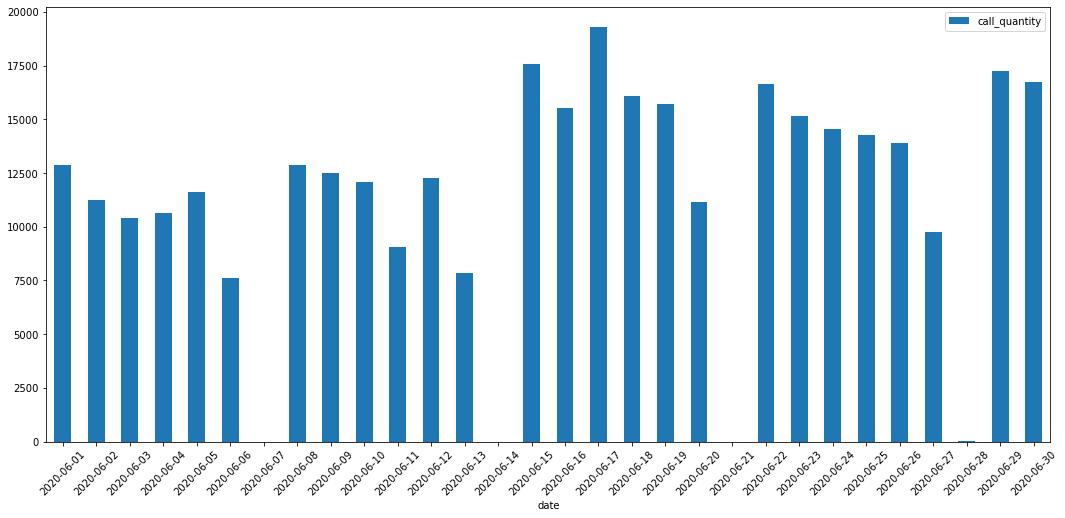

In [129]:
question01Df = executeQuery(query01)
question01Df.plot.bar(x='date', y='call_quantity', rot=0)
plt.rcParams['figure.figsize'] = (18,8)
plt.xticks(rotation=45)
plt.show()

In [149]:
query02="""
  select  dl.midia,
          sum(coalesce(da.monthly_amount, 0)) /
          count(distinct case when da.record_type = 'Venda' then fc.call_id end) as monthly_amount,
          sum(coalesce(da.monthly_amount, 0)) / 
          count(distinct fc.call_id) as call_ticket
  from    fact_call fc
  inner join
          dim_attendance da
  on      da.token_key = fc.token_key
  inner join
          dim_line_mkt dl
  on      dl.line_id = fc.line_id
  group by
          dl.midia
"""

In [150]:
question02Df = executeQuery(query02)
question02Df.head()

,midia,monthly_amount,call_ticket
0,CPC,114.559194,15.788926
1,ORGANIC,116.060749,19.692870
2,SMS,109.798507,13.686512


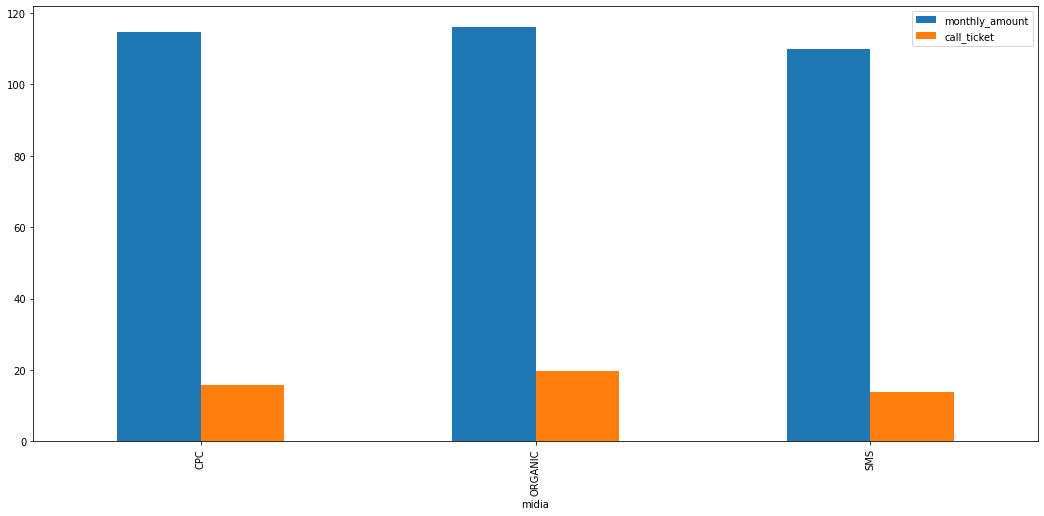

In [153]:
question02Df = executeQuery(query02)
question02Df.plot(x="midia", y=["monthly_amount", "call_ticket"], kind="bar")
plt.rcParams['figure.figsize'] = (18,8)

In [168]:
query03A="""
select dm.midia
      ,count(distinct fc.call_id) as call 
from dim_line_mkt dm
inner join 
         fact_call fc
on    dm.line_id = fc.line_id         
where   fc.modality = 'Entrada'
group by
        dm.midia
"""

In [161]:
question03ADf = executeQuery(query03A)
question03ADf.head()

,midia,call
0,CPC,17109
1,ORGANIC,144966
2,SMS,10380


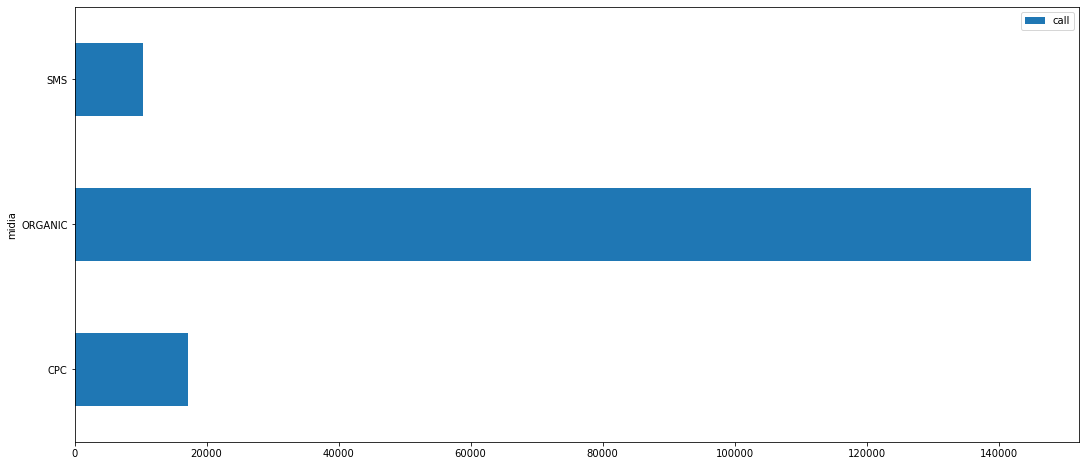

In [169]:
question03ADf = executeQuery(query03A)
question03ADf.plot(x="midia", y=["call"], kind="barh")
plt.rcParams['figure.figsize']= (18,8)

In [170]:
query03B ="""
select 
        dm.campaign
       ,count(distinct fc.call_id) as call_id 
from dim_line_mkt dm
inner join
        fact_call   fc
on    dm.line_id  = fc.line_id    
where fc.modality ='Entrada'
group by 
       dm.campaign
order by 
       call_id asc
limit 20       
"""

In [171]:
question03BDf = executeQuery(query03B)
question03BDf.head()

,campaign,call_id
0,PDP_XY_B2CF_SOCA_CNC_RMK-XY-RCL-OUT-15D-ESC_1,1
1,PDP_ESC_B2CF_SOCA_ATR_INT-IPHONE_1,2
2,ESC_SEOB_ecl_sub,2
3,PDP_XY_B2CF_GDN_CNC_RMK-XY-RCL-CLA-15D-PDP_1,2
4,ESC_SEOB_produtos_internet_sub,2


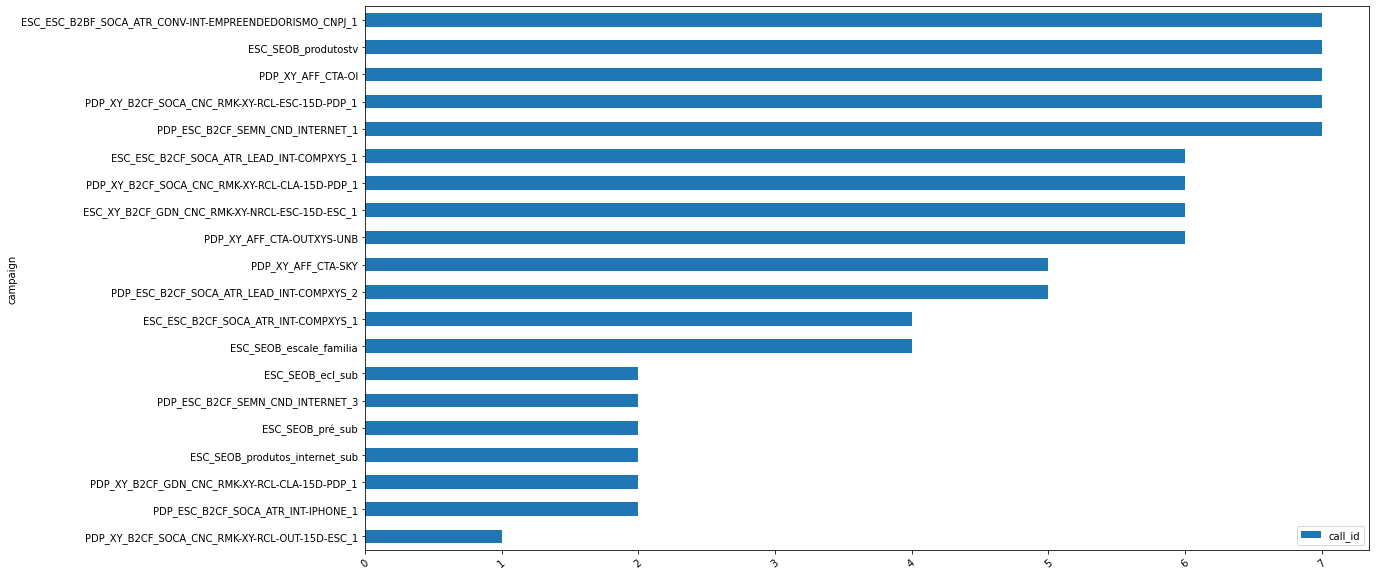

In [173]:
question03BDf = executeQuery(query03B)
question03BDf.plot(x="campaign", y=["call_id"], kind="barh")
plt.xticks(rotation=40)
plt.rcParams['figure.figsize'] = (18,10)
plt.show()

In [174]:
query04="""
select  fc.modality,
        da.record_type,
        coalesce(da.monthly_amount,0) as monthly_amount       
from    fact_call fc
inner join
        dim_attendance da
on      fc.token_key = da.token_key  
where   fc.modality !='Não Vendas'
and     da.record_type = 'Venda'
"""

In [175]:
question04Df = executeQuery(query04)
question04Df.head()

,modality,record_type,monthly_amount
0,Saída,Venda,99.0
1,Entrada,Venda,74.0
2,Entrada,Venda,49.0
3,Entrada,Venda,49.0
4,Entrada,Venda,229.0


<AxesSubplot:xlabel='modality', ylabel='monthly_amount'>

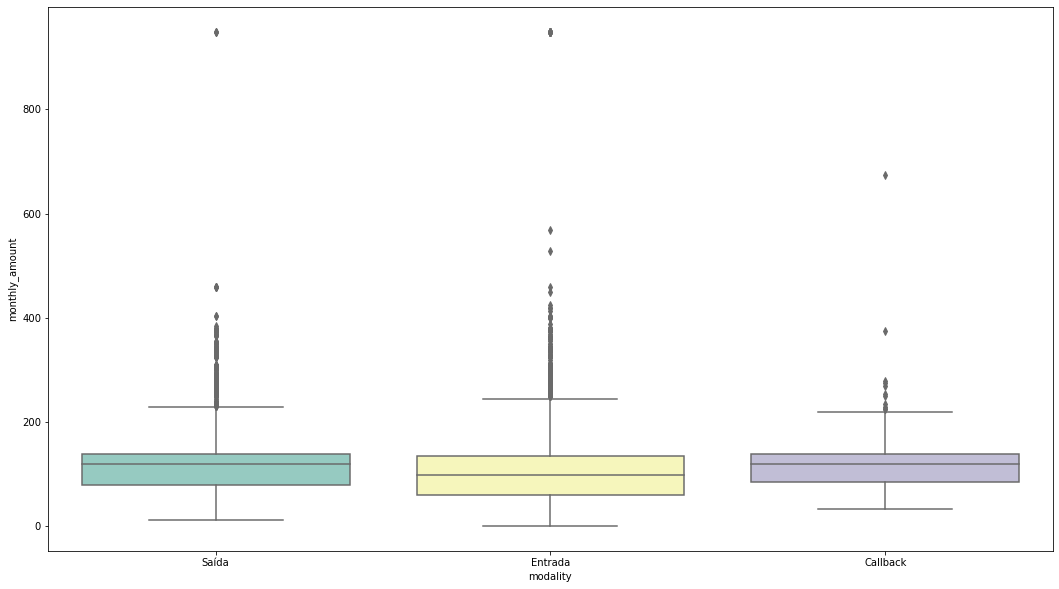

In [181]:
question04Df = executeQuery(query04a)
sns.boxplot(x="modality", y="monthly_amount", data=question04Df, palette="Set3")

In [178]:
query05="""
select fc.uf,
       sum(coalesce(da.monthly_amount, 0)) as monthly_amount
from fact_call fc 
left join
       dim_attendance da
on     fc.token_key = da.token_key  
where da.record_type ='Venda'
group by
        fc.uf
order by 
        monthly_amount asc    
     
       
"""

In [179]:
question05Df = executeQuery(query05)
question05Df.head()

,uf,monthly_amount
0,RR,89.0
1,AP,208.0
2,AC,533.0
3,RO,1333.0
4,TO,2363.0


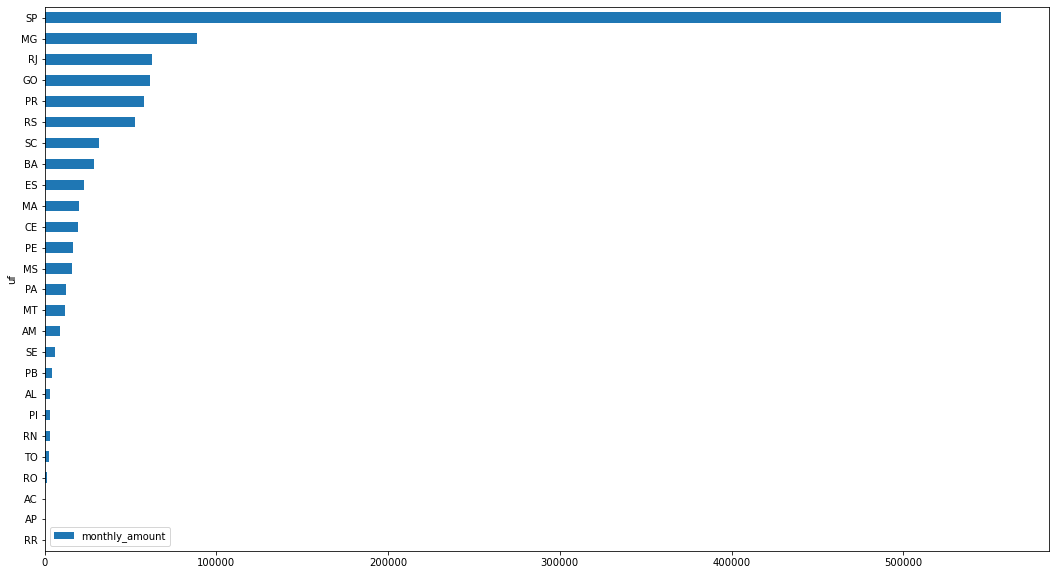

In [180]:
question05Df = executeQuery(query05)
question05Df.plot(x="uf", y="monthly_amount", kind="barh")
plt.rcParams['figure.figsize'] = (18,10)

In [26]:
spark.stop()